In [2]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel

X is a matrix consisting of three columns:
 - time
 - sensor
 - component

In [35]:
X = np.array([[3.0,0],
             [4.0,0],
             [5.0,0],
             [6.0,1],
             [7.0,1],
             [8.0,1],
             [9.0,1],
             [3.0,1],
             [4.0,1],
             [5.0,1],
             [6.0,2],
             [7.0,2],
             [8.0,2],
             [9.0,2]])
X = np.c_[X,np.zeros(len(X))]
S = int(np.max(X[:,1])+1)
C = int(np.max(X[:,2])+1)
Y = np.array([[10,20],[15,30],[16,32],[30,20],[33,22],[21,14],[30,20]])
N = Y.shape[0]
Z = placeinducingpoints(X,S,C,M=5)
refsensor = np.array([1,0,0])

In [36]:
def transform_fn(samps,Y):
    """
    samps should be batch (number of samples) x number of observations (N) x (number of components*2) (C*2)
    Y is N x 2 (the pair of observations made)
    """
    return Y*samps

import gpflow
k = gpflow.kernels.RBF(1,5)+gpflow.kernels.Bias(1)

cs = CalibrationSystem(X, Y, Z, refsensor, N, C, transform_fn, k,likelihoodstd=0.1)

In [37]:
cs.compute()

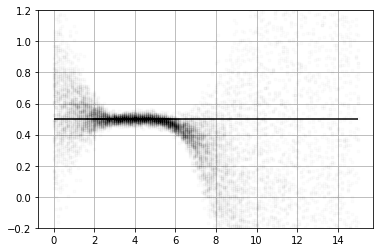

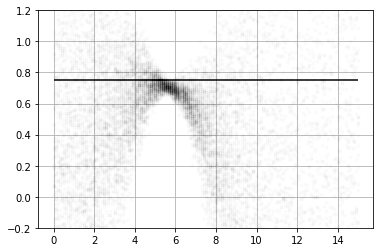

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
#build test matrix

for si in range(1,S):
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,0].numpy().T,'k.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-.2,1.2])
    if si==1: plt.hlines(0.5,0,15)
    if si==2: plt.hlines(0.75,0,15)